In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tf
from PIL import Image

import numpy as np
import pandas as pd

IMG_SIZE = 512

class TurtleRecallDataset(Dataset):
    def __init__(self, path_to_file, path_to_imgs, transforms=None):
        dataframe = pd.read_csv(path_to_file)
        self.path_to_imgs = path_to_imgs
        self.images = np.array(path_to_imgs + '/' + dataframe.image_id + '.JPG')
        self.transforms = transforms
        self.images_id = dataframe.image_id

        if 'turtle_id' in dataframe:
            self.turtle_ids = np.array(dataframe.turtle_id)
            self.targets = np.zeros(len(self.turtle_ids), dtype=np.uint32)
            for target, turtle_id in enumerate(np.unique(self.turtle_ids)):
                self.targets[turtle_id == self.turtle_ids] = target

        if 'image_location' in dataframe:
            self.image_locations = np.array(dataframe.image_location)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        w, h = image.size
        crop_size = min(w, h)
        image = image.crop(
            ((w - crop_size) // 2,
            (h - crop_size) // 2,
            (w + crop_size) // 2,
            (h + crop_size) // 2)
        )
        if self.transforms:
            image = self.transforms(image)
        image = np.array(image)
        return image

In [2]:
"""
Reading train images into numpy array
"""

transforms = tf.Compose([tf.Resize((IMG_SIZE, IMG_SIZE))])
train_dataset = TurtleRecallDataset(path_to_file='../data/train.csv',
                                    path_to_imgs='../data/images',
                                    transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=512, num_workers=4, shuffle=False)
train_images = []

for images in train_loader:
    train_images.append(images)

train_images = np.concatenate(train_images)
train_targets = train_dataset.targets
train_image_locations = train_dataset.image_locations
train_image_locations = np.array([x.lower() for x in train_image_locations])
train_turtle_ids = train_dataset.turtle_ids

print('Train dataset size: ', train_images.shape)

Train dataset size:  (2145, 512, 512, 3)


resnet101 encoder
2 [(7, 23), (15, 24)]
5 [(10, 14)]
15 [(24, 35)]
16 [(1, 7), (8, 24)]
17 [(1, 9)]
21 [(1, 6), (2, 12)]
28 [(0, 3)]
40 [(2, 9), (2, 10), (9, 10)]
45 [(5, 31)]
50 [(1, 5)]
52 [(0, 35)]
54 [(14, 36)]
60 [(1, 7)]
63 [(9, 20)]
65 [(1, 5)]
70 [(0, 28), (4, 12), (22, 26)]
73 [(7, 10)]
76 [(40, 60)]
78 [(0, 10)]
82 [(4, 5)]
84 [(4, 26)]
94 [(9, 40)]
96 [(8, 26)]
Total of duplicated pairs: 30


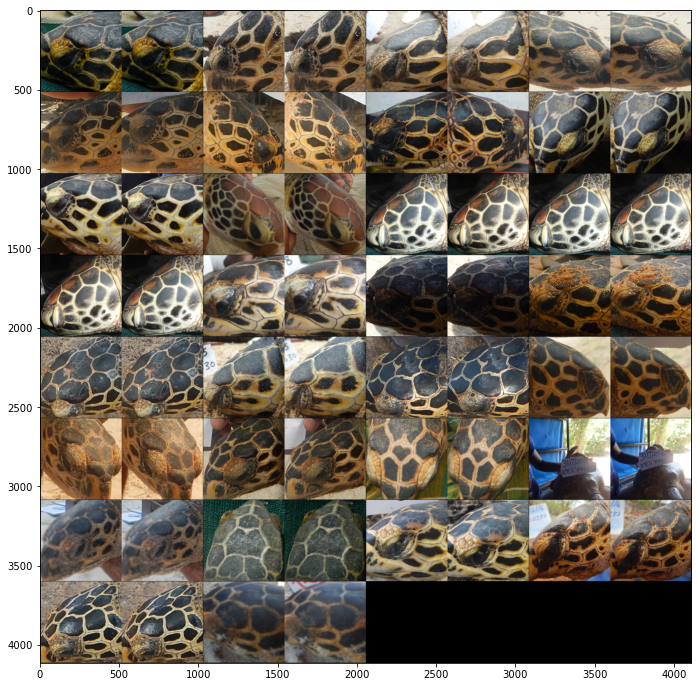

In [3]:
"""
Now, we are going to try to remove duplicated images using cosine similarity
between generated embeddings by trained backbones
"""
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.utils import make_grid
from torchvision import models

import matplotlib.pyplot as plt
import torch.nn as nn
import torch

def find_duplicated_pairs(
    encoders,
    all_images,
    all_targets,
    threshold=0.9,
    device='cuda:0',
):
    transforms = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    duplicated_pairs = {}

    for name, encoder in encoders:
        encoder = encoder.to(device)
        encoder.requires_grad_(False)
        print(f'{name} encoder')
        for target in np.unique(all_targets):
            imgs = all_images[all_targets == target]
            imgs = [transforms(img) for img in imgs]
            imgs = torch.stack(imgs).to(device)
            embeddings = torch.flatten(encoder(imgs), 1)
            embeddings = embeddings.cpu().numpy()
            similarity = cosine_similarity(embeddings)
            similarity[np.eye(len(embeddings), dtype='bool')] = 0
            mask = np.triu(np.where(similarity > threshold, True, False))
            xs, ys = np.where(mask)
            if len(xs):
                if not target in duplicated_pairs:
                    duplicated_pairs[target] = []
                for x, y in zip(xs, ys):
                    if not (x, y) in duplicated_pairs[target]:
                        duplicated_pairs[target].append((x, y))
                print(target, duplicated_pairs[target])
        print('============================================================')

    return duplicated_pairs


THRESHOLD = 0.96
DEVICE = 'cuda:0'

encoders = [
    ('resnet101', nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-1])),
    #('resnet152', nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-1]))
]

duplicated_pairs = find_duplicated_pairs(
    encoders,
    train_images,
    train_targets,
    threshold=THRESHOLD,
    device=DEVICE
)

pair_imgs = np.array([
    np.concatenate(
        [
            train_images[train_targets == target][pair[0]],
            train_images[train_targets == target][pair[1]],
        ],
        axis=1
    )
    for target in duplicated_pairs
    for pair in duplicated_pairs[target]
])

print(f'Total of duplicated pairs: {len(pair_imgs)}')

batch = torch.from_numpy(pair_imgs).permute(0, 3, 1, 2)
grid = make_grid(batch, nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [30]:
"""
Randomly choose one image from duplicated pairs
"""
import random

random.seed(42)

indices_to_delete = []
for k in duplicated_pairs:
    indices = np.flatnonzero(train_targets == k)
    for pair in duplicated_pairs[k]:
        indices_to_delete.append(indices[random.choice(pair)])

train_images = np.delete(train_images, indices_to_delete, axis=0)
train_targets = np.delete(train_targets, indices_to_delete, axis=0)
train_turtle_ids = np.delete(train_turtle_ids, indices_to_delete, axis=0)
train_image_locations = np.delete(train_image_locations, indices_to_delete, axis=0)

print(f'Total of deleted images: {len(indices_to_delete)}')

Total of deleted images: 30


In [31]:
"""
Try to find and delete possible outliers using cosine similarity
between embeddings, discard embeddings whose cosine similarity is lower than
a set threshold
"""
def find_outliers(
    encoders,
    all_images,
    all_targets,
    threshold=0.8,
    device='cuda:0',
):
    transforms = tf.Compose([
        tf.ToPILImage(),
        tf.RandomEqualize(p=1),
        tf.ToTensor(),
        tf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    outliers = {}

    for name, encoder in encoders:
        encoder = encoder.to(device)
        encoder.eval()
        encoder.requires_grad_(False)
        print(f'{name} encoder')
        for target in np.unique(all_targets):
            imgs = all_images[all_targets == target]
            imgs = [transforms(img) for img in imgs]
            imgs = torch.stack(imgs).to(DEVICE)
            embeddings = torch.flatten(encoder(imgs), 1).cpu().numpy()
            similarity = np.mean(cosine_similarity(embeddings), axis=1)
            indices = np.flatnonzero(all_targets == target)[similarity < threshold]
            if len(indices):
                if not target in outliers:
                    outliers[target] = []
                outliers[target].extend(indices)
                outliers[target] = list(np.unique(outliers[target]))
                print(target, outliers[target])
        print('============================================================')

    return outliers

In [46]:
THRESHOLD = 0.845
DEVICE = 'cuda:0'

encoders = [
    #('resnet101', nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-1])),
    ('resnet152', nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-1])),
]

outliers = find_outliers(
    encoders,
    train_images,
    train_targets,
    threshold=THRESHOLD,
    device=DEVICE
)

resnet152 encoder
8 [359]
12 [1840]
14 [1406]
17 [1477]
18 [35]
20 [2080]
25 [1558, 1725]
26 [1036, 1835]
30 [12, 670, 2114]
39 [289, 1224, 1677, 1707]
41 [1726]
42 [1374, 1595]
44 [270, 1246]
48 [1801]
52 [824, 1911]
61 [770]
62 [1929]
63 [264, 407, 659, 784, 1436, 1910, 2015]
65 [4, 1037]
66 [484, 1024, 1913, 1973]
69 [1615]
73 [1656]
76 [550, 1770]
78 [1086]
87 [1506]
95 [415]
96 [209]
99 [1298, 1605]


Total of outliers: 50
(50, 512, 512, 3)


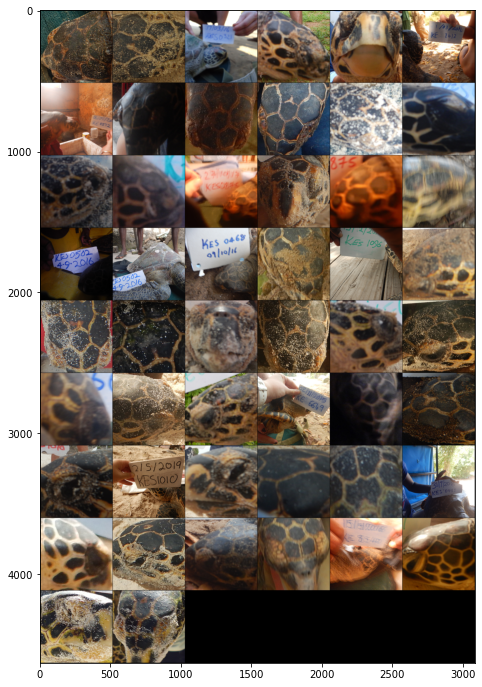

In [47]:
"""
Plot outliers
"""
indices_to_delete = np.concatenate(list(outliers.values()))
outlier_imgs = train_images[indices_to_delete]
print(f'Total of outliers: {len(outlier_imgs)}')

print(outlier_imgs.shape)

batch = torch.from_numpy(outlier_imgs).permute(0, 3, 1, 2)
grid = make_grid(batch, nrow=6)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))

In [48]:
import pickle

train_images = np.delete(train_images, indices_to_delete, axis=0)
train_targets = np.delete(train_targets, indices_to_delete, axis=0)
train_turtle_ids = np.delete(train_turtle_ids, indices_to_delete, axis=0)
train_image_locations = np.delete(train_image_locations, indices_to_delete, axis=0)


train_dataset = {
    'images': train_images,
    'labels': train_targets,
    'turtle_id': train_turtle_ids,
    'image_location': train_image_locations,
}

with open('../data/train_384_384', 'wb') as handle:
    pickle.dump(train_dataset, handle)